We need sktime and statsforecast libraries for the forecast, pmdarima is needed for ARIMA model parameter search. We'll load the same dataset, the airline passengers time series, with sktime and with statsforecast convenience functions.

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

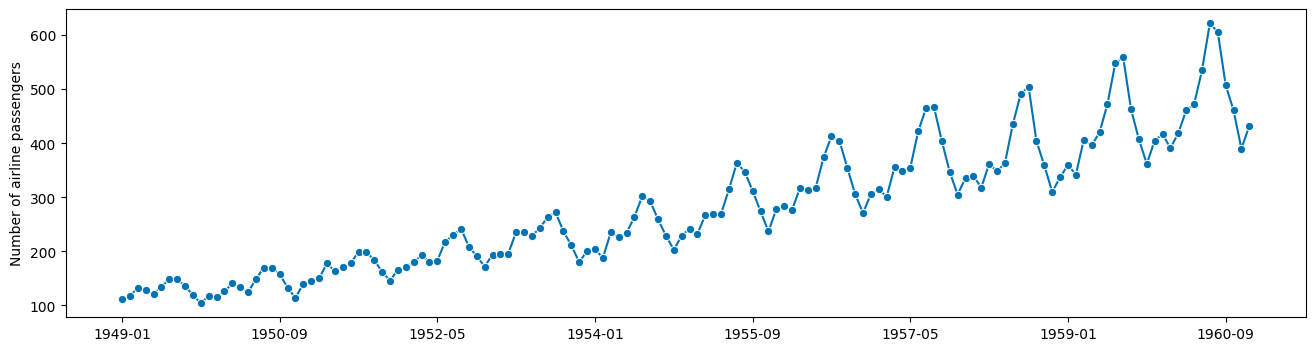

In [1]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

# plotting for visualization
plot_series(y)

In [5]:
from sktime.forecasting.naive import NaiveForecaster

# just taking all the data for fitting
# we'll see how to split data into train and test later
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y)

NaiveForecaster()

In [8]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

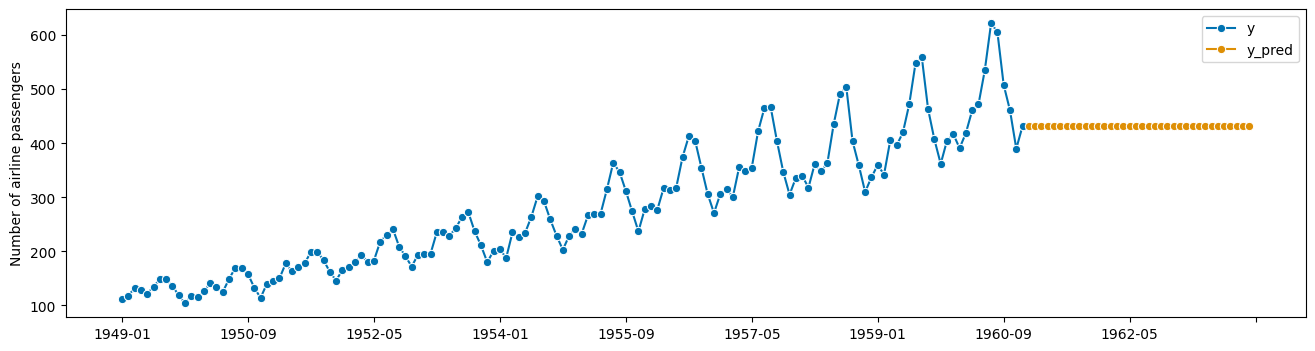

In [9]:
plot_series(y, y_pred, labels=["y", "y_pred"])

In [10]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA()
forecaster.fit(y)
y_pred = forecaster.predict(fh)

/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/b

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

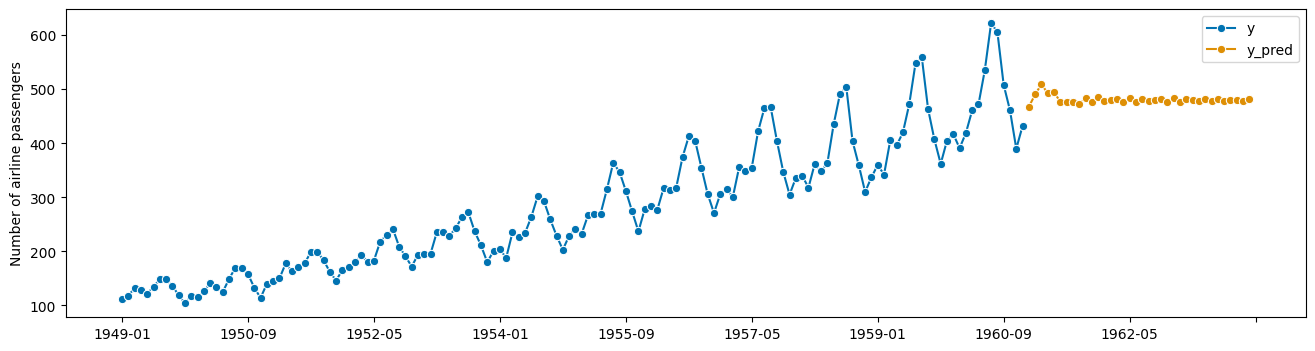

In [11]:
# visualising AutoARIMA fit
plot_series(y, y_pred, labels=["y", "y_pred"])

Using the statsforecast convenience function for loading the same dataset of airline passengers

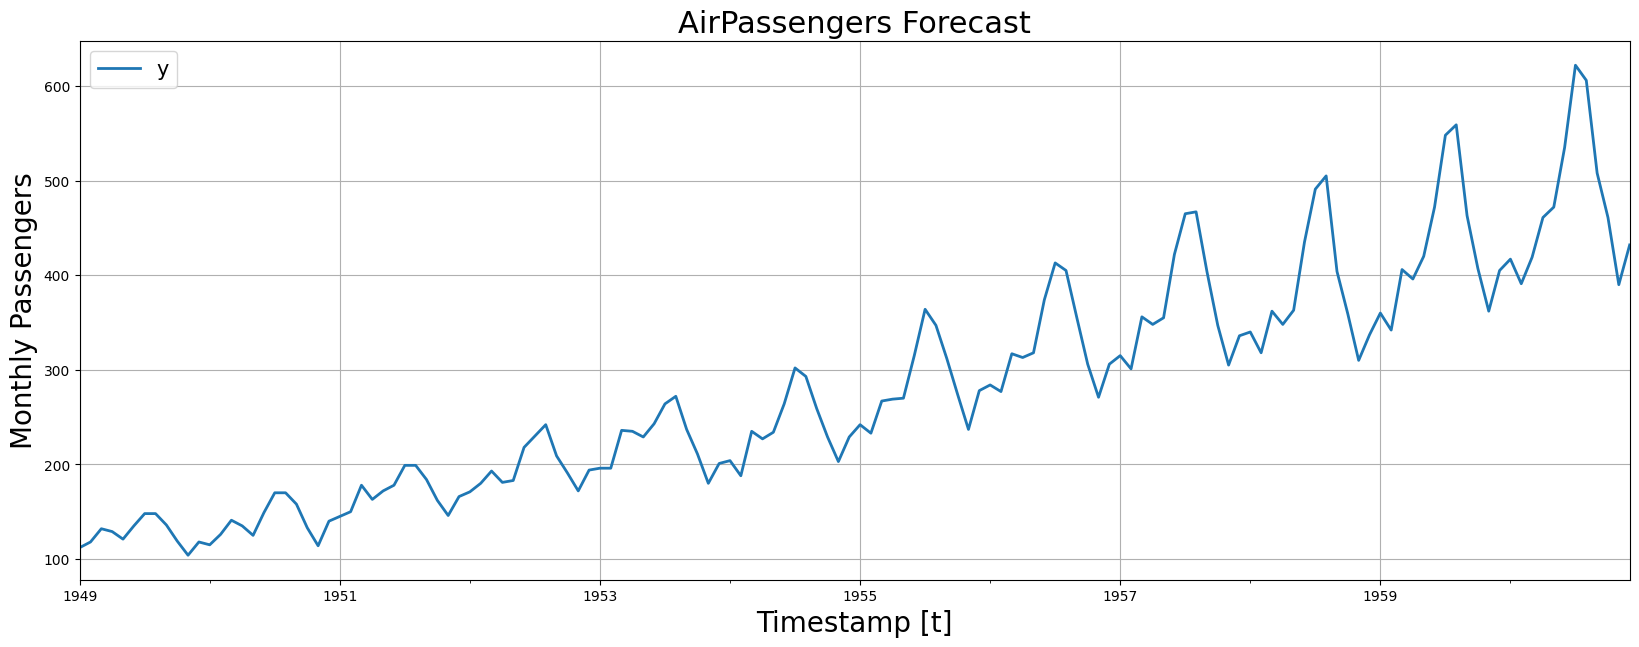

In [17]:
from statsforecast.utils import AirPassengersDF
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = AirPassengersDF.set_index('ds')

plot_df[['y']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [29]:
# let's only train on a subset of the data and see how well the forecast matches the actual data
Y_train_df = AirPassengersDF[AirPassengersDF.ds<='1959-12-31'] # 132 monthly observations for train
Y_test_df = AirPassengersDF[AirPassengersDF.ds>'1959-12-31'] # 12 monthly observations for test

In [21]:
Y_train_df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
127,1.0,1959-08-31,559.0
128,1.0,1959-09-30,463.0
129,1.0,1959-10-31,407.0
130,1.0,1959-11-30,362.0


In [27]:
from statsforecast.models import Naive
from statsforecast import StatsForecast

# The dataframe should be specified as follows:
# `df`: pandas.DataFrame, with columns [`unique_id`, `ds`, `y`] and exogenous.<br>

season_length = 12 # Monthly data 
horizon = len(Y_test_df) # Predict the lenght of the test df

models = [
    Naive()
]
sf = StatsForecast(
    df=Y_train_df,
    models=models,
    freq='M', 
    n_jobs=-1
)
Y_hat_df = sf.forecast(horizon)

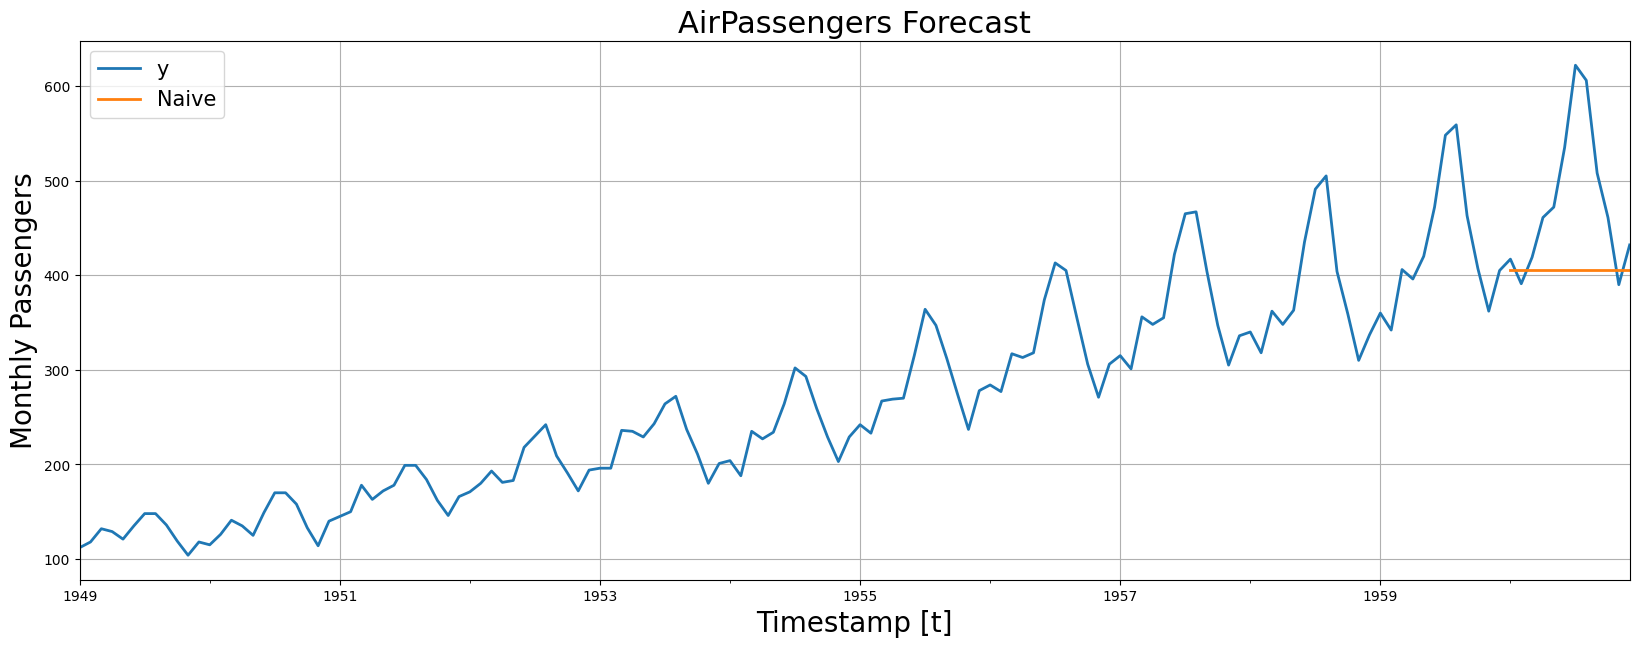

In [28]:
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'Naive']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [32]:
import numpy as np

# we can also calculate errors, for example the MAE
def mae(y_hat, y_true):
    """Alternatively, we could be using sklearn convenience functions."""
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
naive_preds = Y_hat_df['Naive'].values

print('Naive MAE: %0.3f' % mae(naive_preds, y_true))

Naive MAE: 76.000


In [77]:
from statsforecast.models import (
    AutoARIMA, ETS, AutoTheta, AutoCES,
    SimpleExponentialSmoothing, MSTL,
    SeasonalExponentialSmoothing, HoltWinters,
    
)

models = [
    ETS(season_length=season_length),
    Naive(),
    AutoTheta(season_length=season_length),
    AutoARIMA(season_length=season_length),
    AutoCES(season_length=season_length),
    SimpleExponentialSmoothing(alpha=0.2),
    SeasonalExponentialSmoothing(season_length=season_length, alpha=0.2),
    MSTL(season_length=season_length),
]
# There's another interface for triple exponential smoothing: 
# HoltWinters returns the corresponding `ETS` model with additive (A) or multiplicative (M) errors
# (so either 'AAA' or 'MAM').

# I've chosen alpha for exponential smoothing totally at random
# ETS is an Automatic Exponential Smoothing model. It automatically
# selects the best ETS (Error, Trend, Seasonality)


# Instanstiate the StatsForecast class as sf
sf = StatsForecast(
    df=Y_train_df,
    models=models,
    freq='M', 
    n_jobs=-1
)

# Forecast for the defined horizon
Y_hat_df = sf.forecast(horizon)

Y_hat_df.head()

/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsforecast/models.py:526: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


,ds,ETS,Naive,AutoTheta,AutoARIMA,CES,SES,SeasonalES,MSTL
unique_id,,,,,,,,,
1.0,1960-01-31,406.651276,405.0,412.711884,424.160156,410.827393,425.974609,266.422211,418.376953
1.0,1960-02-29,401.732910,405.0,404.640472,407.081696,391.996124,425.974609,256.492340,397.057007
1.0,1960-03-31,456.289642,405.0,466.810883,470.860535,456.414459,425.974609,298.821625,453.961945
1.0,1960-04-30,440.870514,405.0,449.600372,460.913605,447.666779,425.974609,291.245331,443.196991
1.0,1960-05-31,440.333923,405.0,454.047760,484.900879,472.150970,425.974609,299.337891,460.391571


In [78]:
def calculate_errors(Y_test_df, Y_hat_df):
    errors = {}
    for col in Y_hat_df.columns:
        if col in ["y", "ds"]:
            continue
        error = mae(Y_hat_df[col].values, Y_test_df.y.values)
        errors[col] = error
        aggregate_results = pd.DataFrame([errors])
    return aggregate_results

calculate_errors(Y_test_df, Y_hat_df)

,ETS,Naive,AutoTheta,AutoARIMA,CES,SES,SeasonalES,MSTL
0,35.612475,76.0,19.357414,18.550588,10.145073,64.67513,166.727956,11.346949


In [50]:
def plot_forecasts(y_train, y_true, y_pred, models: list[str]):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    if 'ds' in y_pred.columns:
        y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    else:
        y_true = y_true.join(y_pred, how='left')
    df_plot = pd.concat([y_train, y_true]).set_index('ds').tail(24 * 7)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2, style=['r*-','bo--','y^--', 'gx-', 'm.-'])
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()


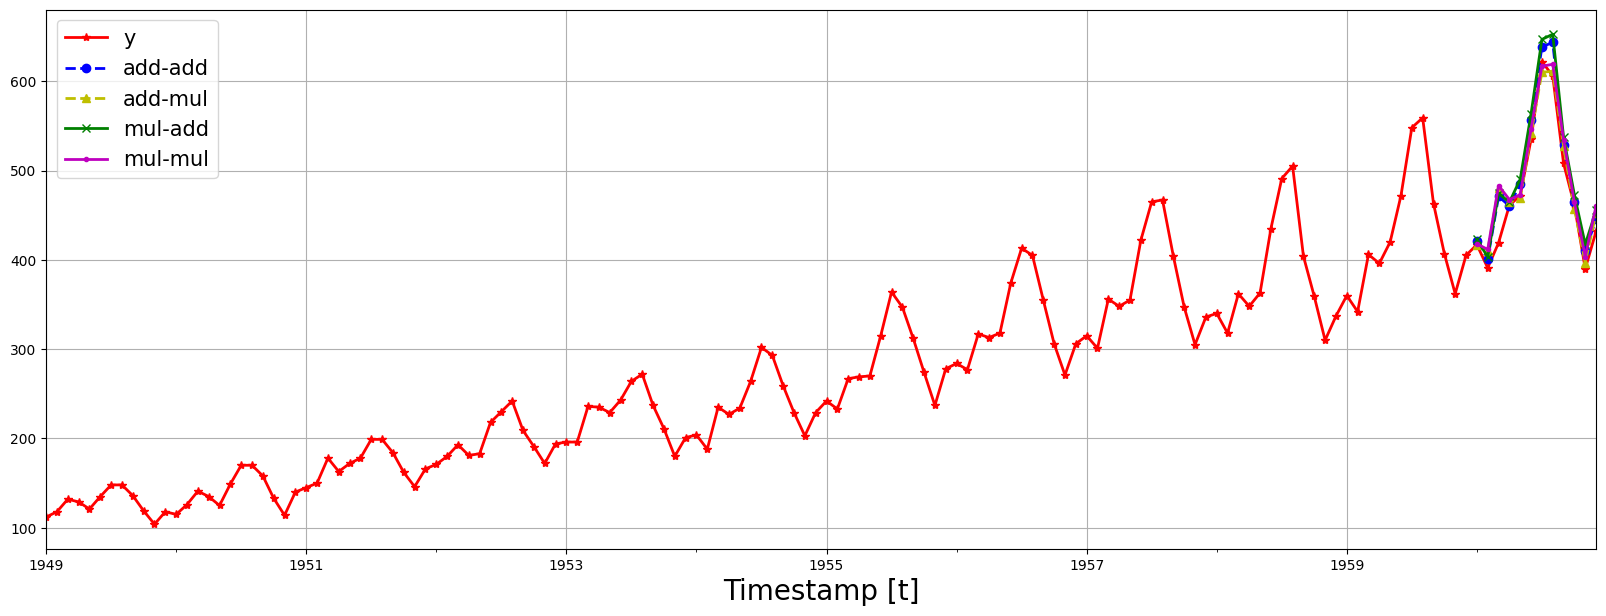

In [80]:
from statsmodels.tsa.api import ExponentialSmoothing

exp_smoothing_results = {}
for trend in ["add", "mul"]:
    for seasonal in ["add", "mul"]:
        mod = ExponentialSmoothing(
            Y_train_df[["y"]],
            seasonal_periods=season_length,
            trend=trend,
            seasonal=seasonal,
            use_boxcox=True,
            initialization_method="estimated",
        ).fit()
        exp_smoothing_results[f"{trend}-{seasonal}"] = mod.forecast(horizon)
    
exp_results_df = pd.DataFrame(data=exp_smoothing_results)
plot_forecasts(
    Y_train_df, Y_test_df, exp_results_df,
    models=list(exp_results_df.columns)
)
Y_hat_df["ETS"] = exp_results_df["add-mul"]
# alternatively, we could use ETS to specify the model
# The state-space equations can be determined based on their $M$ multiplicative, $A$ additive,
# $Z$ optimized or $N$ ommited components. The `model` string parameter defines the ETS equations:
# E in [$M, A, Z$], T in [$N, A, M, Z$], and S in [$N, A, M, Z$].

# For example, ETS(season_length=season_length, model="ZMA") is with optimized error,
# multiplicative trend, and additive seasonality


In [81]:
calculate_errors(Y_test_df, exp_results_df)

,add-add,add-mul,mul-add,mul-mul
0,17.836339,13.470884,23.917536,16.232367


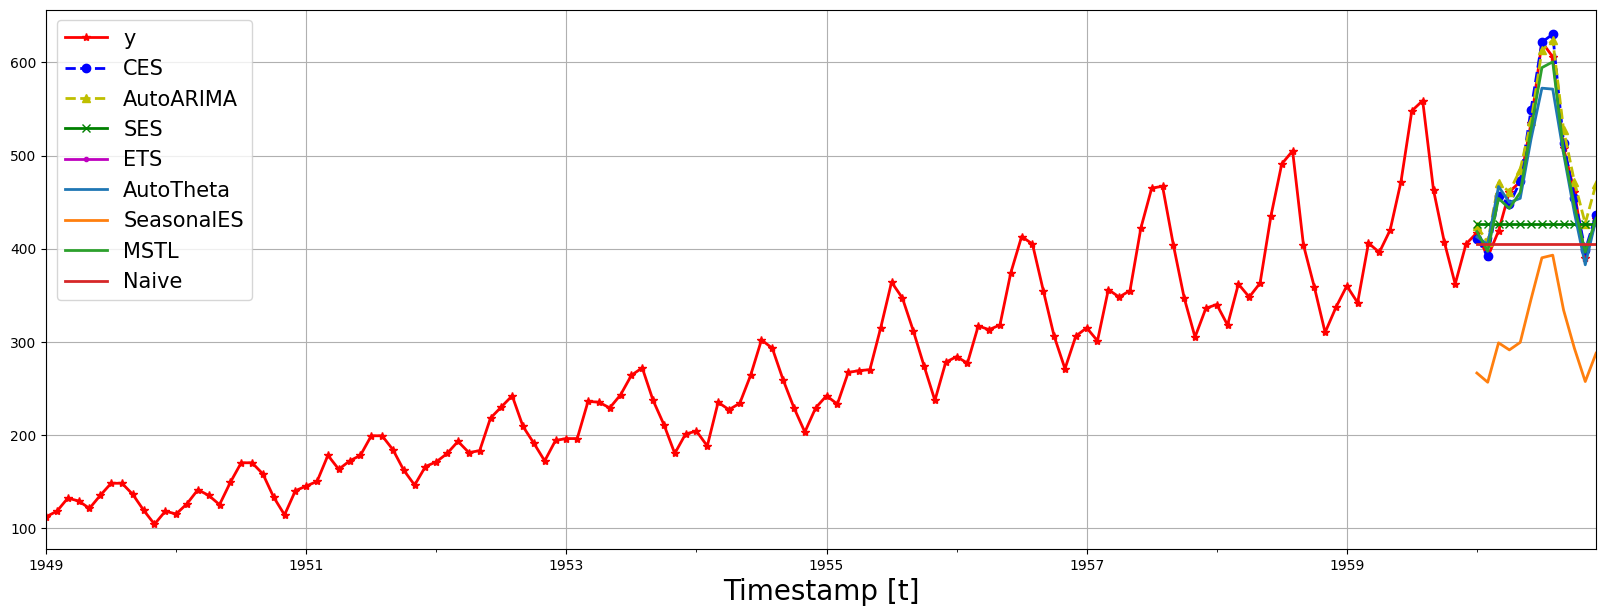

In [82]:
plot_forecasts(
    Y_train_df, Y_test_df, Y_hat_df,
    models=list(set(Y_hat_df.columns) - {"ds"})
)